In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
os.getcwd()

'/Users/sahit/Manoj'

### To change file names of the ECG graphs for convenience

In [3]:
folder_path = './test'
for filename in os.listdir(folder_path):
    old_path = os.path.join(folder_path, filename)
    name, ext = os.path.splitext(filename)
    new_name = str(int(name[-5:]))
    new_name = new_name.strip().lower()
    new_filename = f"{new_name}{ext}"
    new_path = os.path.join(folder_path, new_filename)
    os.rename(old_path, new_path)

ValueError: invalid literal for int() with base 10: 'Store'

### Change column names in the csv file

In [4]:
traindf = pd.read_csv('./y_train.csv')
traindf = traindf.rename(columns={'Unnamed: 0':'filename','G_level_n_h':'target'})
traindf

,filename,target
0,27905,1.0
1,13290,1.0
2,54009,0.0
3,74513,1.0
4,59564,1.0
...,...,...
72535,13261,1.0
72536,14715,1.0
72537,6480,1.0
72538,3442,0.0


In [3]:
testdf = pd.read_csv('./y_test.csv')
testdf = testdf.rename(columns={'Unnamed: 0':'filename','G_level_n_h':'target'})
testdf

,filename,target
0,99039,0.0
1,74046,1.0
2,63868,1.0
3,27490,1.0
4,69853,0.0
...,...,...
18131,21504,1.0
18132,18461,1.0
18133,60826,1.0
18134,103009,0.0


In [6]:
df = pd.concat([traindf,testdf],ignore_index=True)

In [7]:
df

,filename,target
0,27905,1.0
1,13290,1.0
2,54009,0.0
3,74513,1.0
4,59564,1.0
...,...,...
90671,21504,1.0
90672,18461,1.0
90673,60826,1.0
90674,103009,0.0


### Test DF translation

In [5]:
testdf.drop(columns=['filename'],inplace=True)

In [8]:
testdf = testdf.reset_index()

In [10]:
testdf.to_csv("data.csv",index=False)

### End of testing

In [8]:
df = df[df['filename'].isin([i for i in np.arange(18136)])]

In [9]:
df = df.sort_values(by='filename')

In [10]:
df = df.reset_index(drop=True)

In [11]:
df.to_csv('data.csv',index=False)

In [12]:
IMG_DIR = './test'
CSV_FILE = './data.csv'
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
BATCH_SIZE=32
IMG_SIZE = 224
train_transforms = transforms.Compose([
    transforms.Lambda(
        lambda img: transforms.functional.crop(img, top=15, left=89, height=486, width=759)
    ),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3, :, :]),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Validation transforms (no augmentation)
val_transforms = transforms.Compose([
    transforms.Lambda(
        lambda img: transforms.functional.crop(img, top=15, left=89, height=486, width=759)
    ),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3, :, :]),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [14]:
class ECGDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, str(self.annotations.iloc[idx, 0])+'.png')
        image = Image.open(img_name).convert("RGB")
        
        # Numeric label directly from CSV (0 or 1)
        label = int(self.annotations.iloc[idx, 1])
        
        # Apply transforms if any
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [15]:
dataset = ECGDataset(csv_file=CSV_FILE, img_dir=IMG_DIR, transform=train_transforms)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Peek
for imgs, labels in train_loader:
    print("Batch shape:", imgs.shape)   # [B, 3, 224, 224]
    print("Labels:", labels[:10])       # e.g. tensor([0,1,0,1,...])
    break

Batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([1, 0, 1, 0, 0, 0, 1, 1, 1, 0])


## 1. Feature Extractor on PreTrained Model

In [16]:
model = models.resnet50(weights="IMAGENET1K_V1")

# Freeze convolutional layers (feature extractor)
for param in model.parameters():
    param.requires_grad = False

# Replace classifier head
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
def evaluate(model, loader):
    predictions = []
    true_labels = []
    model.eval()
    correct, total, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs,labels)
            val_loss+=loss.item()
            _ , preds = outputs.max(1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return predictions, true_labels, 100 * correct / total,val_loss

def train_model(model, train_loader, val_loader, criterion, epochs=5):
    train_accuracy = []
    val_accuracy = []
    val_losses=[]
    train_losses=[]
    
    
    optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
        
        train_acc = 100 * correct / total
        predictions, true_labels, val_acc, val_loss = evaluate(model, val_loader)
        train_accuracy.append(train_acc)
        val_accuracy.append(val_acc)
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {running_loss/len(train_loader):.4f} | "
              f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    return predictions, true_labels, train_accuracy,val_accuracy,train_losses,val_losses

In [18]:
predictions, true_labels, train_accuracy,val_accuracy,train_losses,val_losses = train_model(model, train_loader, val_loader, criterion, epochs=5)

Epoch [1/5] | Loss: 0.6989 | Train Acc: 50.00% | Val Acc: 49.04%
Epoch [2/5] | Loss: 0.6990 | Train Acc: 49.61% | Val Acc: 50.36%
Epoch [3/5] | Loss: 0.6978 | Train Acc: 50.43% | Val Acc: 49.17%
Epoch [4/5] | Loss: 0.6949 | Train Acc: 51.65% | Val Acc: 49.23%
Epoch [5/5] | Loss: 0.6943 | Train Acc: 51.67% | Val Acc: 50.58%


In [31]:
def plot_confusion_matrix(y_true, y_pred, title, class_names=['Class 0', 'Class 1']):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return cm

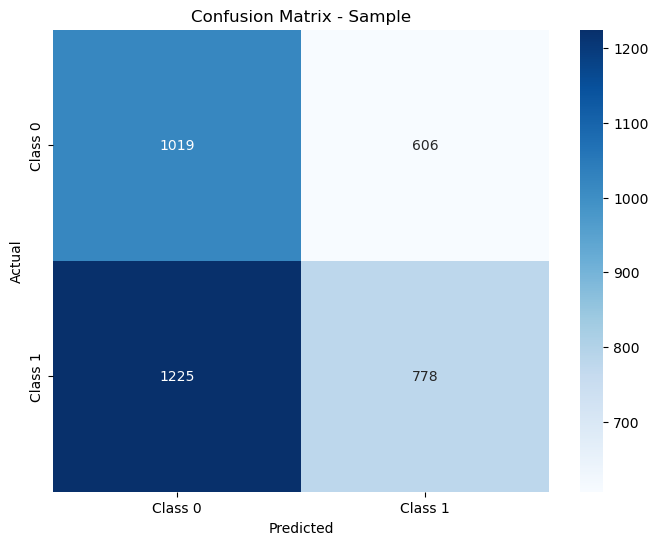

array([[1019,  606],
       [1225,  778]])

In [34]:
plot_confusion_matrix(true_labels,predictions,"Sample")

In [58]:
def plot_curves(train_accuracy,train_losses,val_accuracy, val_losses):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(9,4))
    epochs = range(1,len(train_accuracy)+1)
    ax1.plot(epochs,train_accuracy,'b-',label='Train Accuracy')
    ax1.plot(epochs,val_accuracy,'r-',label='Validation Accuracy')
    ax1.set_title("Accuracy Curve")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    
    ax2.plot(epochs,train_losses,'b-',label='Train Loss')
    ax2.plot(epochs,val_losses,'r-',label='Validation Loss')
    ax2.set_title("Loss Curve")
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
    

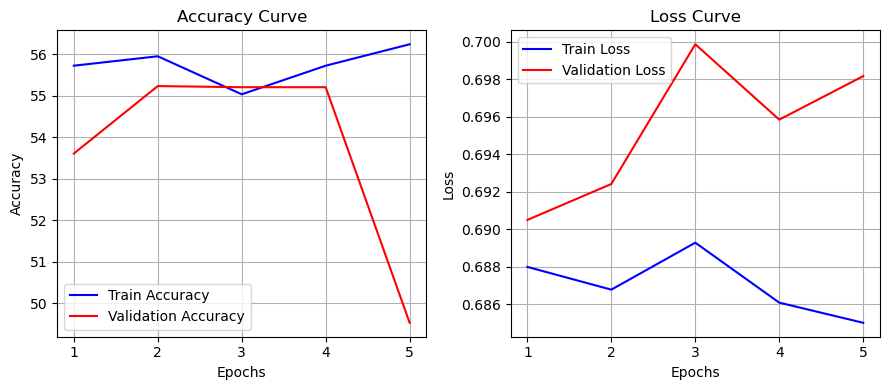

In [59]:
plot_curves(train_accuracy,train_losses,val_accuracy, val_losses)

## 2. Fine-Tuning the PreTrained Model

In [60]:
Finetuned_model = models.resnet50(weights="IMAGENET1K_V1")
Finetuned_model.fc = nn.Linear(model.fc.in_features, 2)
Finetuned_model = Finetuned_model.to(device)

In [61]:
predictions1, true_labels1, train_accuracy1,val_accuracy1,train_losses1,val_losses1 = train_model(Finetuned_model, train_loader, val_loader, criterion, epochs=5)

Epoch [1/5] | Loss: 0.6896 | Train Acc: 55.21% | Val Acc: 54.13%
Epoch [2/5] | Loss: 0.6897 | Train Acc: 55.36% | Val Acc: 55.13%
Epoch [3/5] | Loss: 0.6884 | Train Acc: 55.67% | Val Acc: 54.99%
Epoch [4/5] | Loss: 0.6858 | Train Acc: 55.72% | Val Acc: 54.93%
Epoch [5/5] | Loss: 0.6861 | Train Acc: 56.02% | Val Acc: 54.33%


In [ ]:
full_dataset = datasets.ImageFolder(BASE_DIR, transform=train_transforms)
class_names = full_dataset.classes
print("Total classes:", len(class_names))

# Train/val split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# But apply val transforms separately
val_dataset.dataset.transform = val_transforms

# DataLoaders (streams batches, avoids RAM overflow)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


In [12]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [13]:
image_path = "./test/test_row013298.png"  # Replace with your image path
img = Image.open(image_path)

In [14]:
img.show()

In [21]:
img_rgb = img[:,:,:3]

TypeError: 'PngImageFile' object is not subscriptable

In [22]:
transform_pipeline = transforms.Compose([
        transforms.functional.crop()
        transforms.Resize((256, 256)),  # Resize to 256x256 pixels
        #transforms.RandomHorizontalFlip(), # Randomly flip horizontally
        transforms.ToTensor(),          # Convert PIL Image to PyTorch Tensor
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize
    ])

In [86]:
custom_crop_transform = transforms.Lambda(
        lambda img: transforms.functional.crop(img, top=15, left=89, height=486, width=759)
    )

In [87]:
transformed_img = custom_crop_transform(img)

In [88]:
transformed_img.show()

In [32]:
# For visualization, un-normalize and permute dimensions
# Note: This is an approximation for visualization and might not be exact inverse

for t, m, s in zip(transformed_img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
    t.mul_(s).add_(m)
plt.imshow(img_display.permute(1, 2, 0)) # Change from CHW to HWC for plotting
plt.title("Transformed Image")
plt.show()

TypeError: 'Image' object is not iterable